<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/MEG2Reg_uproot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Writing .comet.config


In [3]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml
!pip install uproot

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 174kB 8.4MB/s 
     |████████████████████████████████| 409kB 10.6MB/s 
     |████████████████████████████████| 204kB 10.9MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=fb7c73b4cc848c801770c4bebce2e69ddffb7c29154bee26cbf947d8977b7c9f
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj
     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 


In [0]:
from comet_ml import Experiment
from comet_ml.exceptions import InterruptedExperiment
import uproot
from datetime import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
from torch.utils.data.dataset import Subset
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.optimize import curve_fit

In [5]:
experiment = Experiment(project_name="CWreg",log_code=True)
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        'train_size':20000,
        'val_size':1000,
        'dropout_conv':0.3,
        'dropout_fc':0.05,
        'optim':"Adam",
        'weight_decay':1e-05,
        'Nresblock':0,
        'Nsd':0,
        'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        'ethreshold':0.0,
        'weightstd':0.01,
        'Nlayer':16,
        'Nfc':0,
        'Nfcnodes':128,
        'Nepoch':5000,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        'stepsize_lr':1, # for lr_test
        # "LRtype":"Step",
        'learning_rate':0.01,
        # 'LRgamma':0.3,
        'LRgamma':0.995,
        'milestones':[200,400,600,800,1000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        "LRtype":"CosExp",
        'stepsize_lr':100,
        'stepsize_lr_down':29,
        'ene_reg':False,
        'pos_reg':True,
        'shw_reg':False,
        'base_lr':0.000001,
        # 'max_lr':0.005,
        
        'UseLPF':False,
        'DoBlind':False
}
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/cwreg/1b2fc5bd942f4886b3996f7dd343de20



In [0]:
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout.csv')
# names=['E','U','V','W','PT','PP','UR','VR','WR']
# PMnames = ['PM%d'%(i) for i in range(4760)]
# names = names+PMnames
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv',names=names)
# csv_data  = pd.read_csv('/content/drive/My Drive/MEG2CW/fout_norm.csv')
file = uproot.open("/content/drive/My Drive/MEG2CW/test.root")
tout = file["tout"]
# file

In [0]:
device = torch.device('cuda:0')

In [0]:
Energy  = tout.array("energy").reshape(-1,1)
EneREC  = tout.array("nsum2").reshape(-1,1)
UVW     = tout.array("uvw_MC").reshape(-1,3)
DIR     = tout.array("gamangle").reshape(-1,2)
SHW     = tout.array("shw_vec").reshape(-1,3)
UVWREC  = tout.array("uvw_rec").reshape(-1,3)
PMResponse = tout.array("Npho").reshape(-1,4760)

In [9]:
Energy

array([[0.881     ],
       [0.780469  ],
       [0.85545005],
       ...,
       [0.881     ],
       [0.881     ],
       [0.63565946]])

(array([8.6317e+04, 3.0860e+03, 2.9000e+02, 2.7000e+01, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00864507e-03, 2.11465684e-01, 4.21922723e-01, 6.32379762e-01,
        8.42836800e-01, 1.05329384e+00, 1.26375088e+00, 1.47420792e+00,
        1.68466496e+00, 1.89512199e+00, 2.10557903e+00]),
 <a list of 10 Patch objects>)

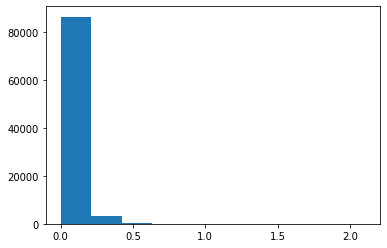

In [10]:
plt.hist(SHW[:,0])

(array([2.0100e+02, 2.5000e+01, 4.8100e+02, 9.4900e+02, 2.3180e+03,
        8.1480e+03, 1.5320e+04, 6.1826e+04, 4.5200e+02, 6.0000e+00]),
 array([0.00425274, 0.11701414, 0.22977554, 0.34253694, 0.45529834,
        0.56805974, 0.68082115, 0.79358255, 0.90634395, 1.01910535,
        1.13186675]),
 <a list of 10 Patch objects>)

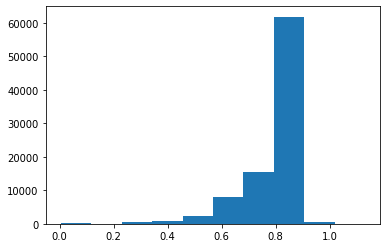

In [11]:
plt.hist(Energy)

In [0]:
# channellist=np.array([2*i for i in range(2380)])
if params["DoBlind"]:
    allchannel =np.array([i for i in range(4760)])
    channellist=np.loadtxt("/content/drive/My Drive/MEG2CW/pmlist.dat",dtype=int,delimiter=',')
    invalidch = set(allchannel)^set(channellist)
    invalidch = list(invalidch)
    len(invalidch)
    # channellist[::4]=0
    PMResponse[0,invalidch]=0

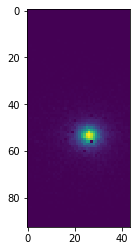

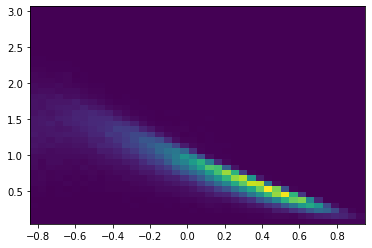

In [14]:
Energy     = Energy.reshape(-1,1)
EneREC     = EneREC.reshape(-1,1)
PMResponse_MPPC,PMResponse_PMT = np.split(PMResponse,[4092],axis=1)
PMResponse_MPPC = PMResponse_MPPC.reshape(-1,93,44)

plt.imshow(PMResponse_MPPC[0])
plt.show()
# indx_U = np.arange(-21.5,22.5)
# indx_V = np.arange(-46,47)
# for i in np.arange(-21.5,22.5):
# PMU = (np.dot(np.sum(PMResponse_MPPC[:],axis=1),indx_U)/np.sum(np.sum(PMResponse_MPPC[:],axis=1),axis=1))/22
# PMV = (np.dot(np.sum(PMResponse_MPPC[:],axis=2),indx_V)/np.sum(np.sum(PMResponse_MPPC[:],axis=2),axis=1))/46.5
# PMU = PMU.reshape(-1,1)
# PMV = PMV.reshape(-1,1)
# PMURMS = np.sqrt(np.mean(np.square(np.sum(PMResponse_MPPC[:],axis=1)),axis=1)).reshape(-1,1)
# PMVRMS = np.sqrt(np.mean(np.square(np.sum(PMResponse_MPPC[:],axis=2)),axis=1)).reshape(-1,1)
# plt.hist2d(UVW[:,2],PMURMS.reshape(-1),bins=[40,40])
# ADD = np.concatenate((PMU,PMV,PMURMS,PMVRMS),axis=1)
COSST = 0.8*np.cos(np.pi*SHW[:,1]).reshape(-1,1)
SINST = 0.8*np.sin(np.pi*SHW[:,1]).reshape(-1,1)
COSSP = 0.8*np.cos(np.pi*SHW[:,2]).reshape(-1,1)
SINSP = 0.8*np.sin(np.pi*SHW[:,2]).reshape(-1,1)
SHW = np.concatenate((SHW[:,0].reshape(-1,1),COSST,SINST,COSSP,SINSP),axis=1)
# print(ADD)

In [0]:
# del csv_data_numpy

In [0]:
PMResponse = PMResponse.reshape(-1,4760)
# PMResponse = PMResponse/PMResponseScale

In [0]:
Energy        = torch.tensor(Energy).float()
EneREC        = torch.tensor(EneREC).float()
UVW           = torch.tensor(UVW).float()
DIR           = torch.tensor(DIR).float()
SHW           = torch.tensor(SHW).float()
# ADD           = torch.tensor(ADD).float()
UVWREC        = torch.tensor(UVWREC).float()
PMResponse    = torch.tensor(PMResponse).float()

In [18]:
# from torch.utils.data.dataset import Subset
BATCH_SIZE = params["batch_size"]
calo_dataset    = utils.TensorDataset(Energy,EneREC,UVW,UVWREC,DIR,SHW,PMResponse)
data_size =  len(calo_dataset)
full_size = int(data_size//1000)*1000
val_size = 500
print(data_size)
# train_dataset = Subset(calo_dataset,list(range(0,full_size-val_size)))
# val_dataset = Subset(calo_dataset,list(range(full_size-val_size,full_size)))
train_dataset = Subset(calo_dataset,list(range(0,params["train_size"])))
val_dataset = Subset(calo_dataset,list(range(params["train_size"],params["train_size"]+params["val_size"])))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=len(val_dataset), 
                                              pin_memory=True, shuffle=True)


89726


In [0]:
# def normal_init(m, mean, std):
#     if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
#         m.weight.data.normal_(mean, std)
#         if m.bias.data is not None:
#             m.bias.data.zero_()

In [0]:
import sys
sys.path.append('/content/drive/My Drive/PySource/')
from NetworkUtil import ResidualBlock
from CosineExp import CosineExpLR
from NetworkUtil import normal_init
from Regressor_MEG import Regressor_MEG

In [0]:
# class Regressor(nn.Module):
#     def __init__(self, dropout_conv =0.0,dropout_fc=0.0,Nresblock=0,Nsd=0,Nlayer=32,Nfc=4,Nfcnodes=256,UseLPF=False):
#         super(Regressor, self).__init__()
#         # self.rconv1 = ReducedConv(1,Nlayer,)
#         self.conv1 = nn.Conv2d(
#             1, 
#             Nlayer, 
#             kernel_size=3, 
#             padding = 2
#             )#(93+4,44+4)->95,46
#         self.conv2 = nn.Conv2d(
#             self.conv1.out_channels, 
#             self.conv1.out_channels*2, 
#             kernel_size=(5, 4), 
#             stride=2
#         )#95,46->46*22
#         self.conv3 = nn.Conv2d(
#             self.conv2.out_channels, 
#             self.conv2.out_channels*2, 
#             4
#             ,stride=2
#         )#46*22->22,10
#         self.conv4 = nn.Conv2d(
#             self.conv3.out_channels, 
#             self.conv3.out_channels*2, 
#             4
#             ,stride=2
#         )#22*10->10,4
#         self.convsd = nn.Conv2d(
#             self.conv1.out_channels, 
#             self.conv1.out_channels, 
#             3,
#             padding=1
#         )#6*6->6*3 
#         self.rb = ResidualBlock(self.conv1.out_channels)
#         self.UseLPF = UseLPF
#         if self.UseLPF:
#             self.fcstart = nn.Linear(self.conv4.out_channels*40+668+7,Nfcnodes)
#         else:
#             self.fcstart = nn.Linear(self.conv4.out_channels*40+668+4,Nfcnodes)
#         # self.fcstart = nn.Linear(self.conv4.out_channels*40+668+4,Nfcnodes)
#         self.Nfc = Nfc
#         self.fc=[nn.Linear(self.fcstart.out_features//2**i,self.fcstart.out_features//2**(i+1)).to(device) for i in range(self.Nfc)]
#         self.fcend = nn.Linear(self.fcstart.out_features//2**(Nfc),9)
        
#         self.bn1 = nn.BatchNorm2d(self.conv1.out_channels)
#         self.bn2 = nn.BatchNorm2d(self.conv2.out_channels)
#         self.bn3 = nn.BatchNorm2d(self.conv3.out_channels)
#         self.bn4 = nn.BatchNorm2d(self.conv4.out_channels)
#         self.dropout1 = nn.Dropout(dropout_conv)
#         self.dropoutfc = nn.Dropout(dropout_fc)
#         self.Nresblock = Nresblock
#         self.Nsd = Nsd
        
#     def forward(self, x, add):
#         x = x.view(x.shape[0],-1)
#         x_mppc,x_pmt = torch.split(x,4092,dim=1)
#         x_mppc = x_mppc.view(x_mppc.shape[0],1,93,44)
#         x_mppc = F.relu(self.bn1(self.conv1(x_mppc)))
#         for i in range(self.Nresblock):
#             x_mppc = self.dropout1(self.rb(x_mppc))
#         for i in range(self.Nsd):
#             x_mppc = F.relu(self.dropout1(self.bn1(self.convsd(x_mppc))))
#         x_mppc = F.relu(self.dropout1(self.bn2(self.conv2(x_mppc))))
#         x_mppc = F.relu(self.dropout1(self.bn3(self.conv3(x_mppc))))
#         x_mppc = F.relu(self.dropout1(self.bn4(self.conv4(x_mppc))))
        
#         x_mppc = x_mppc.view(x_mppc.shape[0],self.conv4.out_channels*40)
#         x = torch.cat([x_mppc,x_pmt,add],dim=1)
#         x = F.relu(self.fcstart(x))
#         for i in range(self.Nfc):
#             x = F.relu(self.dropoutfc(self.fc[i](x)))
#         # x = F.relu(self.dropoutfc(self.fc3(x)))
#         # x = F.relu(self.dropoutfc(self.fc4(x)))
#         x = self.fcend(x)
#         return torch.tanh(x)
#     def weight_init(self, mean, std):
#         for m in self._modules:
#             normal_init(self._modules[m], mean, std)

In [22]:
model = Regressor_MEG(
    params["dropout_conv"],
    params["dropout_fc"],
    params["Nresblock"],
    params["Nsd"],
    params['Nlayer'],
    params['Nfc'],
    params['Nfcnodes']
    ).to(device)
    
print(model)
model.weight_init(mean=0.0, std=params['weightstd'])

Regressor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 4), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (convsd): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rb): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.0)
  )
  (fcstart): Linear(in_features=5792, out_features=128, bias=True)
  (fcend): Linear(in_features=128, out_features=9, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm

In [0]:
# learning_rate = 0.001
# opt = optim.Adam(regressor.parameters(), lr=learning_rate)
opt = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
if params["LRtype"]=="Cyclic":
    scheduler = CyclicLR(opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler = MultiStepLR(opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler = StepLR(opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler = CosineAnnealingLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
elif params["LRtype"]=="CosExp":
    scheduler = CosineExpLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

In [0]:
Energy_mean, UVW_mean, DIR_mean,SHW_mean = Energy.mean(dim=0).to(device), UVW.mean(dim=0).to(device), DIR.mean(dim=0).to(device),SHW.mean(dim=0).to(device)
UVWE_mean = torch.cat([UVW_mean,Energy_mean]).to(device)
UVWESHW_mean = torch.cat([UVW_mean,Energy_mean,SHW_mean]).to(device)
UVWDIR_mean = torch.cat([UVW_mean, DIR_mean]).to(device)
def metric_relative_mse(y_pred,y_true):
    y_true_mean = y_true.mean(dim=0)
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWE_mean).pow(2).mean(dim=0)).sum()).sqrt()
    return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWESHW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWESHW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVW_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true[:,2] - y_pred[:,2]).pow(2).mean(dim=0) / (y_true[:,2] - UVW_mean[2]).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - UVWDIR_mean).pow(2).mean(dim=0)).sum()).sqrt()
    # return (((y_true - y_pred).pow(2).mean(dim=0) / (y_true - Energy_mean).pow(2).mean(dim=0)).sum()).sqrt()

In [0]:
# loss_fn = torch.nn.SmoothL1Loss().to(device)
loss_fn = torch.nn.L1Loss().to(device)

In [0]:
ranges=[2,2,4,2,3,50,50]

def run_training(epochs=100):
    # iterating over epochs...
    ibatch = 0
    for epoch in tqdm(range(epochs)):
        first = True
        with experiment.train():
            for Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b in train_dataloader:
            # moving them to device(for example, cuda-device)
                Energy_b, EneREC_b, UVW_b, UVWREC_b, DIR_b, SHW_b,  PMResponse_b = Energy_b.to(device), \
                                                EneREC_b.to(device), \
                                                UVW_b.to(device), \
                                                UVWREC_b.to(device), \
                                                DIR_b.to(device), \
                                                SHW_b.to(device), \
                                                PMResponse_b.to(device)

    #             pred = regressor(EnergyDeposit_b)
                model.train()
                UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
                UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
                # if params["UseLPF"]:
                #     pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                # else:
                #     pred = model(PMResponse_b,ADD_b)
                if params["pos_reg"] and params["shw_reg"]:
                    TGT_b = torch.cat([UVW_b,SHW_b])
                elif params["pos_reg"]:
                    TGT_b = UVW_b
                loss            = loss_fn(pred, TGT_b)
                # loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                # loss        = loss_fn(pred[:,0:3], UVW_b)
                # loss_rec    = loss_fn(UVWREC_b, UVW_b)
                # loss        = loss_fn(pred, Energy_b)

                # model.train()
                opt.zero_grad()
                loss.backward()
                opt.step()
                # if params["LRtype"]=="Cyclic":
                #     scheduler.step()
                ibatch+=1
            experiment.log_metric("learning_rate", scheduler.get_lr(),step=epoch)
            # if params["LRtype"]!="Cyclic":
            scheduler.step()
            with torch.no_grad():
                model.eval()
                if params["UseLPF"]:
                    pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                else:
                    pred = model(PMResponse_b,ADD_b)
                # train_mse       = metric_relative_mse(pred, UVW_b).item()
                # train_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
                train_mse            = metric_relative_mse(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                train_mse_rec        = metric_relative_mse(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
            
            experiment.log_metric("train_loss", loss.item(),step=epoch)
            experiment.log_metric("train_mse", train_mse,step=epoch)
            experiment.log_metric("train_loss_rec", loss_rec.item(),step=epoch)
            experiment.log_metric("train_mse_rec", train_mse_rec,step=epoch)
        # scheduler.step()
        with experiment.test():
            for Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b in val_dataloader:
        # moving them to device(for example, cuda-device)
                Energy_b, EneREC_b,  UVW_b, UVWREC_b, DIR_b, SHW_b, ADD_b, PMResponse_b = Energy_b.to(device), \
                                                EneREC_b.to(device), \
                                                UVW_b.to(device), \
                                                UVWREC_b.to(device), \
                                                DIR_b.to(device), \
                                                SHW_b.to(device), \
                                                ADD_b.to(device), \
                                                PMResponse_b.to(device)

                break

    #             pred = regressor(EnergyDeposit_b)
            with torch.no_grad():
                model.eval()
                # UVWDIR_b = torch.cat([UVW_b,DIR_b],dim=1)
                # UVWDIRrec_b = torch.cat([UVWREC_b,DIR_b],dim=1)
                # pred = model(PMResponse_b,UVWREC_b)
                # pred = model(PMResponse_b,torch.zeros(UVW_b.shape[0],3).to(device))
                # pred = model(PMResponse_b,ADD_b)
                if params["UseLPF"]:
                    pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                else:
                    pred = model(PMResponse_b,ADD_b)
                # print(pred)
                # pred = model(PMResponse_b,torch.cat([ADD_b,UVWREC_b],dim=1))
                # val_loss        = loss_fn(pred[:,0:3], UVW_b)
                # val_loss_rec    = loss_fn(UVWREC_b, UVW_b)
                # val_mse       = metric_relative_mse(pred, UVW_b).item()
                # val_mse_rec   = metric_relative_mse(UVWREC_b, UVW_b).item()
                # val_loss            = loss_fn(pred, torch.cat([UVW_b,Energy_b],dim=1))
                # val_loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b],dim=1), torch.cat([UVW_b,Energy_b],dim=1))
                val_loss            = loss_fn(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                val_loss_rec        = loss_fn(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1))
                val_mse            = metric_relative_mse(pred, torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                val_mse_rec        = metric_relative_mse(torch.cat([UVWREC_b,EneREC_b,SHW_b],dim=1), torch.cat([UVW_b,Energy_b,SHW_b],dim=1)).item()
                
                # val_mse   = metric_relative_mse(pred, Energy_b).item()
                # val_mse   = 0
            experiment.log_metric("val_loss", val_loss.item(),step=epoch)
            experiment.log_metric("val_loss_rec", val_loss_rec.item(),step=epoch)
            experiment.log_metric("val_mse", val_mse,step=epoch)
            experiment.log_metric("val_mse_rec", val_mse_rec,step=epoch)

            w_real   = 40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-0.01)
            ene_pred = 20*pred[:,3].cpu().detach().numpy()
            ene_raw  = 20*EneREC_b[:,0].cpu().detach().numpy()
            shwl_real = 40*SHW_b[:,0].cpu().detach().numpy()
            du       = 40*(UVW_b[:,0].cpu().detach().numpy()-pred[:,0].cpu().detach().numpy())
            dv       = 80*(UVW_b[:,1].cpu().detach().numpy()-pred[:,1].cpu().detach().numpy())
            dw       = 40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-np.exp((pred[:,2].cpu().detach().numpy()-1)*2.5))
            
            du_lpf   = 40*(UVW_b[:,0].cpu().detach().numpy()-UVWREC_b[:,0].cpu().detach().numpy())
            dv_lpf   = 80*(UVW_b[:,1].cpu().detach().numpy()-UVWREC_b[:,1].cpu().detach().numpy())
            dw_lpf   = 40*(np.exp((UVW_b[:,2].cpu().detach().numpy()-1)*2.5)-np.exp((UVWREC_b[:,2].cpu().detach().numpy()-1)*2.5))
            # w_sep = [1,3.5,7.5,20]
            w_sep      = [2*i+1 for i in range(10)]
            dw_dep     = [np.sqrt(np.mean((dw[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            dw_dep_lpf = [np.sqrt(np.mean((dw_lpf[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            du_dep     = [np.sqrt(np.mean((du[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            du_dep_lpf = [np.sqrt(np.mean((du_lpf[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            dv_dep     = [np.sqrt(np.mean((dv[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            dv_dep_lpf = [np.sqrt(np.mean((dv_lpf[(w_real > 2*i)&(w_real < 2*(i+1))])**2)) for i in range(10)]
            dene     = 20*(Energy_b[:,0].cpu().detach().numpy()-pred[:,3].cpu().detach().numpy())
            dene_raw = 20*(Energy_b[:,0].cpu().detach().numpy()-EneREC_b[:,0].cpu().detach().numpy())
            dshwl = 40*(SHW_b[:,0].cpu().detach().numpy()-pred[:,4].cpu().detach().numpy())
            # dshwt = 180/math.pi*angle_two_vectors(SHW_b[:,1:3],pred[:,5:7]).cpu().detach().numpy()
            # dshwp = 180/math.pi*angle_two_vectors(SHW_b[:,3:5],pred[:,7:9]).cpu().detach().numpy()
            # dshwt = 180/math.pi*angle_between(SHW_b[:,1:3].cpu().detach().numpy(),pred[:,5:7].cpu().detach().numpy())
            # dshwp = 180/math.pi*angle_between(SHW_b[:,3:5].cpu().detach().numpy(),pred[:,7:9].cpu().detach().numpy())
            # dshwt = np.zeros(SHW_b[:,1].cpu().detach().numpy().shape[0])
            shwt = np.arctan2(pred[:,6].cpu().detach().numpy(),pred[:,5].cpu().detach().numpy())
            shwp = np.arctan2(pred[:,8].cpu().detach().numpy(),pred[:,7].cpu().detach().numpy())
            shwt_real = np.arctan2(SHW_b[:,2].cpu().detach().numpy(),SHW_b[:,1].cpu().detach().numpy())
            shwp_real = np.arctan2(SHW_b[:,4].cpu().detach().numpy(),SHW_b[:,3].cpu().detach().numpy())
            rawdshwt = 180/math.pi*(shwt_real-shwt)
            rawdshwp = 180/math.pi*(shwp_real-shwp)
            rawdshwt_gam = 180/math.pi*(shwt_real-np.pi*DIR_b[:,0].cpu().detach().numpy())
            rawdshwp_gam = 180/math.pi*(shwp_real-np.pi*DIR_b[:,1].cpu().detach().numpy())
            dshwt = np.zeros(rawdshwt.shape[0])
            dshwp = np.zeros(rawdshwp.shape[0])
            dshwt_gam = np.zeros(rawdshwt.shape[0])
            dshwp_gam = np.zeros(rawdshwp.shape[0])
            for i in range(len(rawdshwt)):
                if rawdshwt[i]<-180:  dshwt[i] = rawdshwt[i] + 360
                elif rawdshwt[i]>180: dshwt[i] = rawdshwt[i] - 360
                else: dshwt[i] = rawdshwt[i]

            for i in range(len(rawdshwp)):
                if rawdshwp[i]<-180:  dshwp[i] = rawdshwp[i] + 360
                elif rawdshwp[i]>180: dshwp[i] = rawdshwp[i] - 360
                else: dshwp[i] = rawdshwp[i]
            
            for i in range(len(rawdshwt_gam)):
                if rawdshwt_gam[i]<-180:  dshwt_gam[i] = rawdshwt_gam[i] + 360
                elif rawdshwt_gam[i]>180: dshwt_gam[i] = rawdshwt_gam[i] - 360
                else: dshwt_gam[i] = rawdshwt_gam[i]

            for i in range(len(rawdshwp_gam)):
                if rawdshwp_gam[i]<-180:  dshwp_gam[i] = rawdshwp_gam[i] + 360
                elif rawdshwp_gam[i]>180: dshwp_gam[i] = rawdshwp_gam[i] - 360
                else: dshwp_gam[i] = rawdshwp_gam[i]
            # print(dshwp[abs(dshwp)>180])


            resolution_u     = np.sqrt(np.mean((du)**2))
            resolution_v     = np.sqrt(np.mean((dv)**2))
            resolution_w     = np.sqrt(np.mean((dw)**2))
            
            resolution_u_lpf = np.sqrt(np.mean((du_lpf)**2))
            resolution_v_lpf = np.sqrt(np.mean((dv_lpf)**2))
            resolution_w_lpf = np.sqrt(np.mean((dw_lpf)**2))
            
            resolution_e     = np.sqrt(np.mean((dene)**2))
            resolution_e_raw = np.sqrt(np.mean((dene_raw)**2))
            resolution_shwl  = np.sqrt(np.mean((dshwl)**2))
            resolution_shwt  = np.sqrt(np.mean((dshwt[shwl_real>5])**2,axis=0))
            resolution_shwp  = np.sqrt(np.mean((dshwp[shwl_real>5])**2,axis=0))
            resshwl_dep = [np.sqrt(np.mean((dshwl[(shwl_real > 2*i)&(shwl_real < 2*(i+1))])**2)) for i in range(10)]
            resshwt_dep = [np.sqrt(np.mean((dshwt[(shwl_real > 2*i)&(shwl_real < 2*(i+1))])**2)) for i in range(10)]
            resshwp_dep = [np.sqrt(np.mean((dshwp[(shwl_real > 2*i)&(shwl_real < 2*(i+1))])**2)) for i in range(10)]
            resshwt_gam_dep = [np.sqrt(np.mean((dshwt_gam[(shwl_real > 2*i)&(shwl_real < 2*(i+1))])**2)) for i in range(10)]
            resshwp_gam_dep = [np.sqrt(np.mean((dshwp_gam[(shwl_real > 2*i)&(shwl_real < 2*(i+1))])**2)) for i in range(10)]
            # fraction = 0
            # for i in range(len(Energy_b)):
            #     if 180/math.pi*abs(np.arctan2(SHW_b[i,3].cpu().detach().numpy(),SHW_b[i,4].cpu().detach().numpy())-
            #                     np.arctan2(pred[i,7].cpu().detach().numpy(),pred[i,8].cpu().detach().numpy()))>50:
            #         print(180/math.pi*abs(np.arctan2(SHW_b[i,3].cpu().detach().numpy(),SHW_b[i,4].cpu().detach().numpy())-
            #                     np.arctan2(pred[i,7].cpu().detach().numpy(),pred[i,8].cpu().detach().numpy())))
            #         fraction+=1/float(len(Energy_b))
            # print(fraction)
            experiment.log_metric("e_resolution"    , resolution_e    ,step=epoch)
            experiment.log_metric("e_resolution_raw", resolution_e_raw,step=epoch)
            experiment.log_metric("u_resolution", resolution_u,step=epoch)
            experiment.log_metric("v_resolution", resolution_v,step=epoch)
            experiment.log_metric("w_resolution", resolution_w,step=epoch)
            experiment.log_metric("u_resolution_lpf", resolution_u_lpf,step=epoch)
            experiment.log_metric("v_resolution_lpf", resolution_v_lpf,step=epoch)
            experiment.log_metric("w_resolution_lpf", resolution_w_lpf,step=epoch)
            experiment.log_metric("shwl_resolution"    , resolution_shwl    ,step=epoch)
            experiment.log_metric("shwt_resolution"    , resolution_shwt    ,step=epoch)
            experiment.log_metric("shwp_resolution"    , resolution_shwp    ,step=epoch)
        if epoch%10==0:
            plt.figure(figsize=(35,12))
            grid = plt.GridSpec(2, 7, wspace=0.4, hspace=0.3)
            for idim in range(7):
                if idim==0:
                    plt.subplot(grid[0,idim])
                    plt.hist(du    ,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2,label="CNN")
                    plt.hist(du_lpf,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2,label="LPF")
                    plt.xlabel(r'$\Delta_{u}[cm]$')
                    plt.legend(loc="upper left")
                    plt.title("U Deviation")
                    plt.subplot(grid[1,idim])
                    # plt.hist2d(w_real,du,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                    plt.scatter(w_sep,du_dep,color='b',label="ML")
                    plt.scatter(w_sep,du_dep_lpf,color='r',label="LPF")
                    plt.legend(loc="upper left")
                    plt.ylim(0,2)
                    plt.xlabel("Depth[cm]")
                    plt.ylabel(r'$RMS(\Delta_{u})[cm]$')
                elif idim==1:
                    plt.subplot(grid[0,idim])
                    plt.hist(dv    ,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2,label="CNN")
                    plt.hist(dv_lpf,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2,label="LPF")
                    plt.title("V Deviation")
                    plt.legend(loc="upper left")
                    plt.xlabel(r'$\Delta_{v}[cm]$')
                    plt.subplot(grid[1,idim])
                    plt.scatter(w_sep,dv_dep,color='b',label="ML")
                    plt.scatter(w_sep,dv_dep_lpf,color='r',label="LPF")
                    plt.legend(loc="upper left")
                    plt.ylim(0,2)
                    plt.xlabel("Depth[cm]")
                    plt.ylabel(r'$RMS(\Delta_{v})[cm]$')
                    # plt.hist2d(w_real,dv,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                elif idim==2:
                    plt.subplot(grid[0,idim])
                    plt.hist(dw    ,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2,label="CNN")
                    plt.hist(dw_lpf,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2,label="LPF")
                    plt.title("W Deviation")
                    plt.legend(loc="upper left")
                    plt.xlabel(r'$\Delta_{w}[cm]$')
                    plt.subplot(grid[1,idim])
                    plt.scatter(w_sep,dw_dep    ,color='b',label="ML")
                    plt.scatter(w_sep,dw_dep_lpf,color='r',label="LPF")
                    plt.legend(loc="upper left")
                    plt.ylim(0,2)
                    plt.xlabel("Depth[cm]")
                    plt.ylabel(r'$RMS(\Delta_{w})[cm]$')
                    # plt.hist2d(w_real,dw,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                elif idim==3:
                    plt.subplot(grid[0,idim])
                    plt.hist(dene    ,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(dene_raw,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                    plt.title("%f"%(resolution_e))
                    plt.subplot(grid[1,idim])
                    # plt.hist2d(w_real,dene,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                    plt.hist(ene_pred  ,histtype='step',range=(15,20),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.hist(ene_raw   ,histtype='step',range=(15,20),bins=80,color='r',fill=False,edgecolor='r',lw=2)
                elif idim==4:
                    plt.subplot(grid[0,idim])
                    plt.hist(dshwl,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2)
                    plt.title("%f"%(resolution_shwl))
                    plt.subplot(grid[1,idim])
                    plt.scatter(w_sep,resshwl_dep    ,color='b',label="ML")
                    # plt.scatter(w_sep,resshwt_gam_dep    ,color='r',label="Gamma")
                    plt.ylim(0,10)
                    plt.legend(loc="upper left")
                    plt.xlabel("Length of Shower[cm]")
                    plt.ylabel(r'$RMS(\Delta_{L_{s}})[deg]$')
                    # plt.hist2d(w_real,dshwl,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                elif idim==5:
                    plt.subplot(grid[0,idim])
                    plt.hist(dshwt,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2,label="CNN")
                    plt.hist(dshwt_gam,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2,label="Gamma")
                    plt.title(r'$\Delta_{\theta_{s}}[deg]$')
                    plt.legend(loc="upper left")
                    plt.xlabel(r'$\Delta_{\theta_{s}}[deg]$')
                    plt.subplot(grid[1,idim])
                    plt.scatter(w_sep,resshwt_dep    ,color='b',label="ML")
                    plt.scatter(w_sep,resshwt_gam_dep    ,color='r',label="Gamma")
                    plt.ylim(0,40)
                    plt.legend(loc="upper left")
                    plt.xlabel("Length of Shower[cm]")
                    plt.ylabel(r'$RMS(\Delta_{\theta_{s}})[deg]$')
                    # plt.hist2d(w_real,dshwt,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
                elif idim==6:
                    plt.subplot(grid[0,idim])
                    plt.hist(dshwp,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='b',fill=False,edgecolor='b',lw=2,label="CNN")
                    plt.hist(dshwp_gam,histtype='step',range=(-ranges[idim],ranges[idim]),bins=80,color='r',fill=False,edgecolor='r',lw=2,label="Gamma")
                    plt.title(r'$\Delta_{\phi_{s}}[deg]$')
                    plt.legend(loc="upper left")
                    plt.xlabel(r'$\Delta_{\phi_{s}}[deg]$')
                    plt.subplot(grid[1,idim])
                    plt.scatter(w_sep,resshwp_dep    ,color='b',label="ML")
                    plt.scatter(w_sep,resshwp_gam_dep    ,color='r',label="Gamma")
                    plt.ylim(0,40)
                    plt.legend(loc="upper left")
                    plt.xlabel("Length of Shower[cm]")
                    plt.ylabel(r'$RMS(\Delta_{\phi_{s}})[deg]$')
                    # plt.hist2d(w_real,dshwp,range=[[0,10],[-ranges[idim],ranges[idim]]],bins = [40,40],norm=LogNorm())
            #  torch.pred
                
            # plt.show()
            experiment.log_figure(figure=plt)
            plt.close()
        

In [0]:
#  with experiment.train():
run_training(params["Nepoch"])


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 502/5000 [29:58<4:53:40,  3.92s/it]

In [0]:
experiment.end()